## CASO 1

In [3]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
import matplotlib.pyplot as plt
from torch_geometric.data import Data

torch.manual_seed(42)

d = 4

n_P1 = 100 # NUMERO DE SENADORES P1
n_P2 = 80 # NUMERO DE SENADORES P2
n_L1 = 200 # NUMERO DE LEYES P1
n_L2 = 150 # NUMERO DE LEYES P2
n_L3 = 60 # NUMERO DE LEYES NEUTRAS

P1_L1 = 0.9 ## Votos de senadores del partido 1 a leyes grupo 1
P1_L2 = 0.01 ## Votos de senadores del partido 1 a leyes grupo 2
P1_L3 = 0.2 ## Votos de senadores del partido 1 a leyes grupo 3
P2_L1 = 0.1 ## Votos de senadores del partido 2 a leyes grupo 1
P2_L2 = 0.8 ## Votos de senadores del partido 2 a leyes grupo 2
P2_L3 = 0.3 ## Votos de senadores del partido 2 a leyes grupo 3

p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 20
n_P2_np = 10
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.7).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

## GD GRDPG 

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 400

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  12
Loss:  tensor(117.2344)
tensor(119.4353, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.4677, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.3212, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.3187, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.3161, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


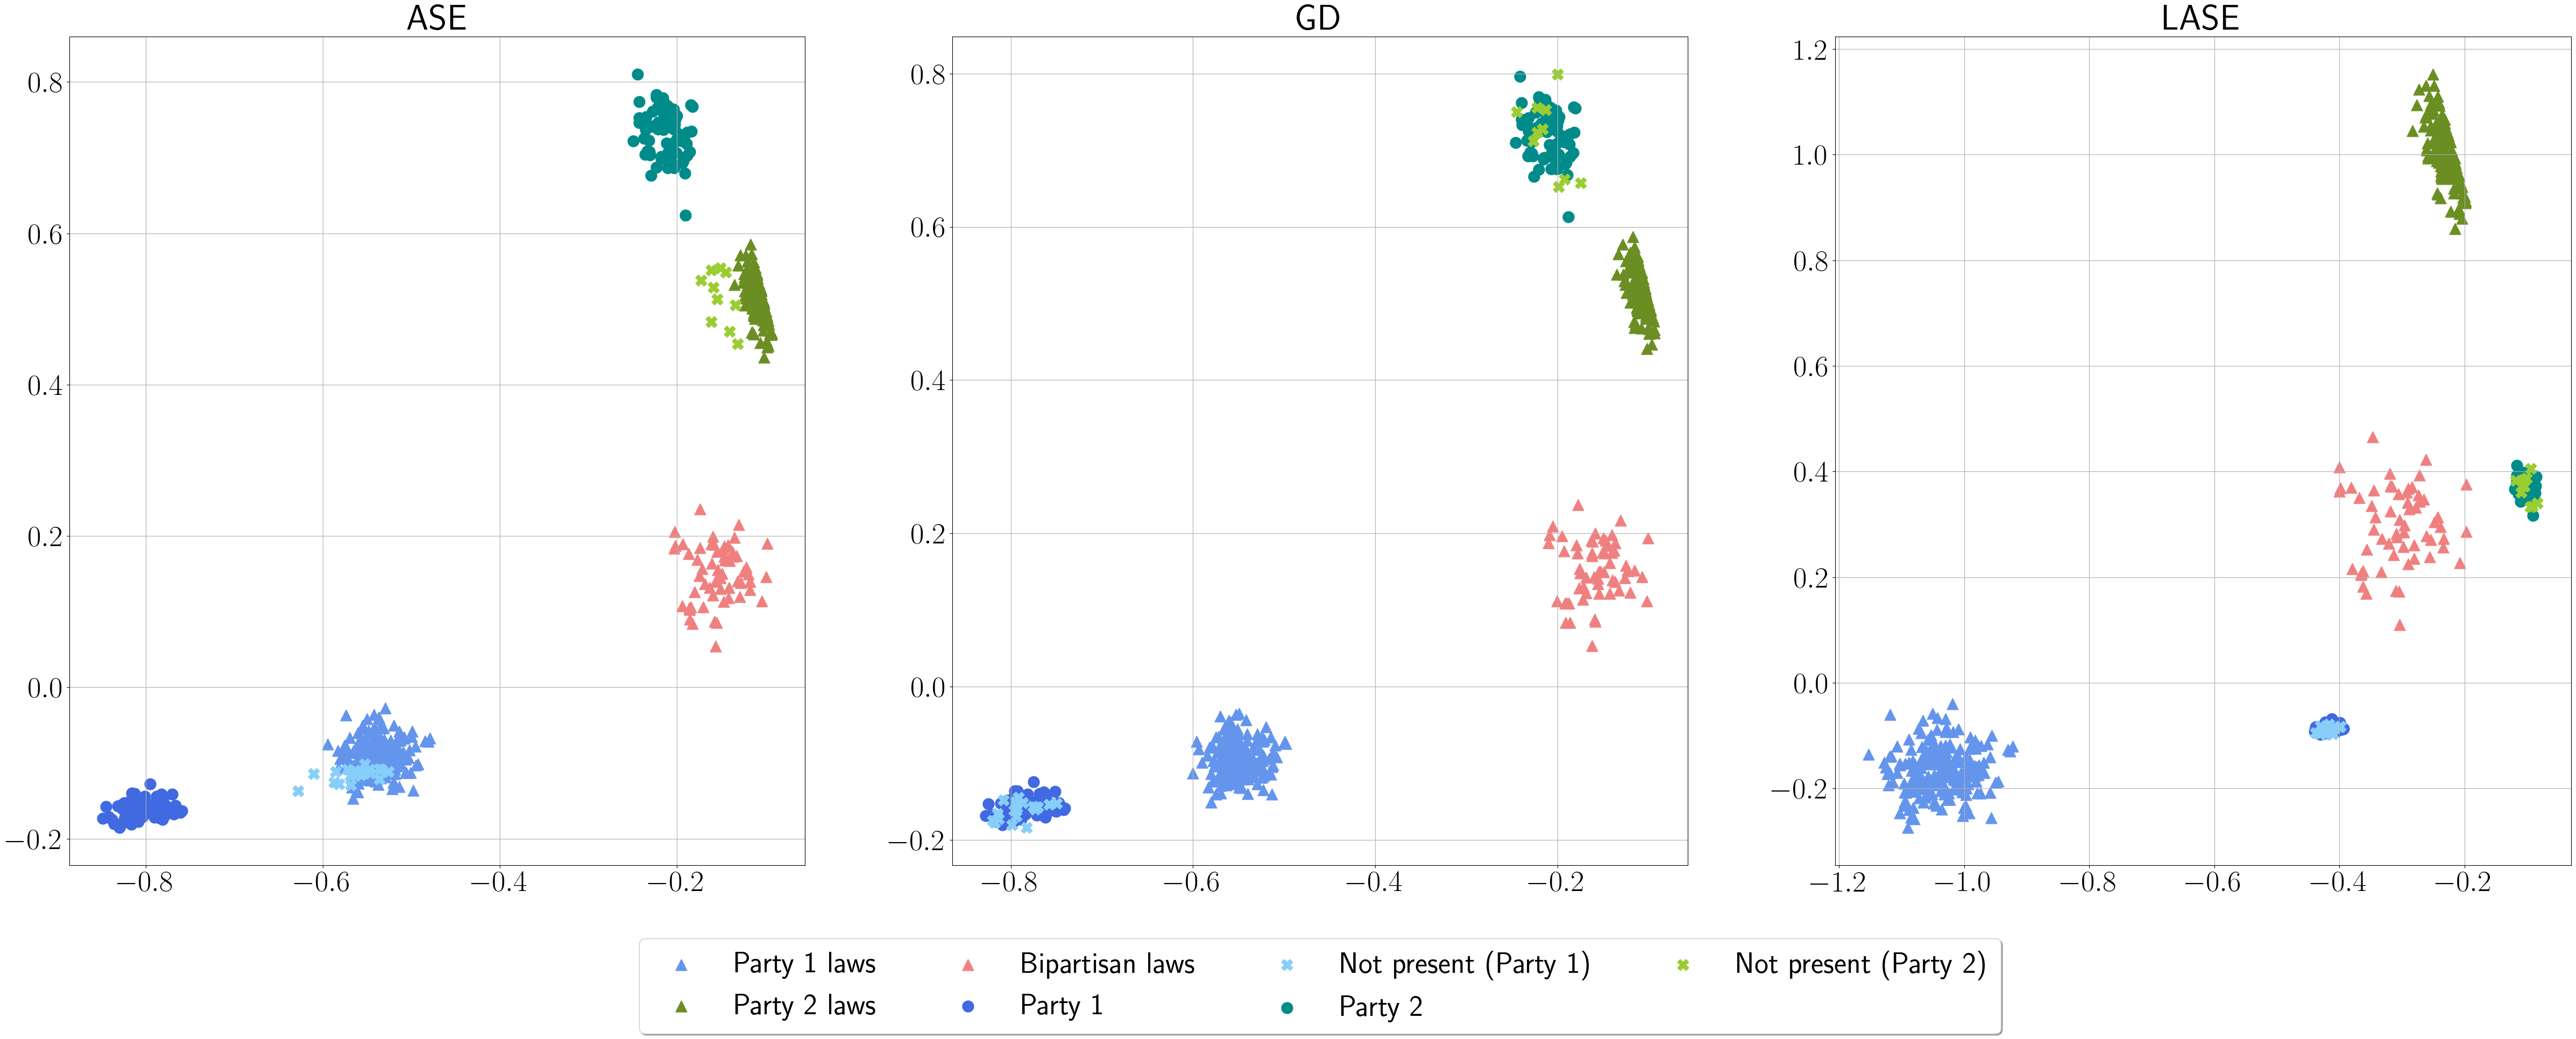

In [7]:

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 40
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True



fig, axes = plt.subplots(1, 3, figsize =(60,20))



axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='olivedrab',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='lightcoral',marker='^',label='Bipartisan laws')
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='lightskyblue',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='darkcyan',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='yellowgreen',marker='X',label='Not present (Party 2)')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='olivedrab',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='lightcoral',marker='^',label='Bipartisan laws')
axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='lightskyblue',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='darkcyan',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='yellowgreen',marker='X',label='Not present (Party 2)')

axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='olivedrab',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='lightcoral',marker='^',label='Bipartisan laws')
axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='lightskyblue',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='darkcyan',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='yellowgreen',marker='X',label='Not present (Party 2)')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


In [8]:
from training.run_link_prediction import link_prediction_Transformer

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.3401, ASE acc: 0.7522, GD-GRDPG acc: 0.7545, GLASE acc: 0.7543, GLASE E2E acc: 0.7553


In [2]:
from training.run_link_prediction import link_prediction

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.3409, ASE acc: 0.7538, GD-GRDPG acc: 0.7538, GLASE acc: 0.7541, GLASE E2E acc: 0.7530


In [2]:
from training.run_link_prediction import link_prediction_GAT

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_GAT(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.3327, ASE acc: 0.7510, GD-GRDPG acc: 0.7557, GLASE acc: 0.7596, GLASE E2E acc: 0.7367


In [2]:
from training.run_link_prediction import link_prediction_Transformer

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, acc_gcn, acc_ase, acc_grdpg, acc_glase = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4, with_e2e=False)
acc_glase_e2e = 0
print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.3577, ASE acc: 0.7042, GD-GRDPG acc: 0.7431, GLASE acc: 0.7067, GLASE E2E acc: 0.0000


In [2]:
from training.run_link_prediction import link_prediction_GraphTransformer

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, acc_gcn, acc_ase, acc_grdpg, acc_glase = link_prediction_GraphTransformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4, with_e2e=False)

acc_glase_e2e = 0
print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

/home/sofia/lase/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


GCN acc: 0.3472, ASE acc: 0.7505, GD-GRDPG acc: 0.7528, GLASE acc: 0.7538, GLASE E2E acc: 0.0000


In [2]:
from training.run_link_prediction import link_prediction_GraphTransformer

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_GraphTransformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4, with_e2e=True)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

Data(x=[590, 5], edge_index=[2, 60098], x_init=[590, 4], x_ase=[590, 4], x_glase=[590, 4], x_grdpg=[590, 4])
tensor(0.3550)


/home/sofia/lase/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


(tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        ...,
        [0.2943, 0.9129, 0.6215, 0.2907, 0.1633],
        [0.1562, 0.9035, 0.0430, 0.9321, 0.9000],
        [0.5310, 0.4599, 0.8889, 0.7205, 0.9728]], device='cuda:0'), tensor([[-0.5820, -0.5812, -0.1277, -0.1278],
        [-0.5526, -0.5520, -0.1015, -0.1016],
        [-0.5685, -0.5678, -0.1289, -0.1290],
        ...,
        [-0.1364,  0.1365,  0.1734, -0.1733],
        [-0.1598,  0.1598,  0.1219, -0.1218],
        [-0.1546,  0.1547,  0.1793, -0.1791]], device='cuda:0'))
tensor(0.7394)
tensor(0.7472)
GCN acc: 0.3550, ASE acc: 0.7394, GD-GRDPG acc: 0.7472, GLASE acc: 0.7536, GLASE E2E acc: 0.7510


# CASO 1 - 0.5

In [9]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
import matplotlib.pyplot as plt
from torch_geometric.data import Data

torch.manual_seed(42)

d = 4

n_P1 = 100 # NUMERO DE SENADORES P1
n_P2 = 80 # NUMERO DE SENADORES P2
n_L1 = 200 # NUMERO DE LEYES P1
n_L2 = 150 # NUMERO DE LEYES P2
n_L3 = 60 # NUMERO DE LEYES NEUTRAS

P1_L1 = 0.9 ## Votos de senadores del partido 1 a leyes grupo 1
P1_L2 = 0.01 ## Votos de senadores del partido 1 a leyes grupo 2
P1_L3 = 0.2 ## Votos de senadores del partido 1 a leyes grupo 3
P2_L1 = 0.1 ## Votos de senadores del partido 2 a leyes grupo 1
P2_L2 = 0.8 ## Votos de senadores del partido 2 a leyes grupo 2
P2_L3 = 0.3 ## Votos de senadores del partido 2 a leyes grupo 3

p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 20
n_P2_np = 10
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.5).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

## GD GRDPG 

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 400

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(115.3328)
tensor(119.7031, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.4501, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.4058, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.4047, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.4036, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [10]:
from training.run_link_prediction import link_prediction_Transformer

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.3632, ASE acc: 0.7418, GD-GRDPG acc: 0.7545, GLASE acc: 0.7466, GLASE E2E acc: 0.7397


# CASO 1 - 0.3

In [11]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
import matplotlib.pyplot as plt
from torch_geometric.data import Data

torch.manual_seed(42)

d = 4

n_P1 = 100 # NUMERO DE SENADORES P1
n_P2 = 80 # NUMERO DE SENADORES P2
n_L1 = 200 # NUMERO DE LEYES P1
n_L2 = 150 # NUMERO DE LEYES P2
n_L3 = 60 # NUMERO DE LEYES NEUTRAS

P1_L1 = 0.9 ## Votos de senadores del partido 1 a leyes grupo 1
P1_L2 = 0.01 ## Votos de senadores del partido 1 a leyes grupo 2
P1_L3 = 0.2 ## Votos de senadores del partido 1 a leyes grupo 3
P2_L1 = 0.1 ## Votos de senadores del partido 2 a leyes grupo 1
P2_L2 = 0.8 ## Votos de senadores del partido 2 a leyes grupo 2
P2_L3 = 0.3 ## Votos de senadores del partido 2 a leyes grupo 3

p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 20
n_P2_np = 10
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.3).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

## GD GRDPG 

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 400

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(113.4157)
tensor(118.6889, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.8932, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.4736, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.4723, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.4705, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [12]:
from training.run_link_prediction import link_prediction_Transformer

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.5970, ASE acc: 0.7520, GD-GRDPG acc: 0.7499, GLASE acc: 0.7534, GLASE E2E acc: 0.7513


# CASO 1 - 0.1

In [13]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
import matplotlib.pyplot as plt
from torch_geometric.data import Data

torch.manual_seed(42)

d = 4

n_P1 = 100 # NUMERO DE SENADORES P1
n_P2 = 80 # NUMERO DE SENADORES P2
n_L1 = 200 # NUMERO DE LEYES P1
n_L2 = 150 # NUMERO DE LEYES P2
n_L3 = 60 # NUMERO DE LEYES NEUTRAS

P1_L1 = 0.9 ## Votos de senadores del partido 1 a leyes grupo 1
P1_L2 = 0.01 ## Votos de senadores del partido 1 a leyes grupo 2
P1_L3 = 0.2 ## Votos de senadores del partido 1 a leyes grupo 3
P2_L1 = 0.1 ## Votos de senadores del partido 2 a leyes grupo 1
P2_L2 = 0.8 ## Votos de senadores del partido 2 a leyes grupo 2
P2_L3 = 0.3 ## Votos de senadores del partido 2 a leyes grupo 3

p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 20
n_P2_np = 10
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

## GD GRDPG 

x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 400

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(111.3243)
tensor(114.3514, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.9869, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(112.6764, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(112.0074, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(111.7379, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [15]:
from training.run_link_prediction import link_prediction_Transformer

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.6081, ASE acc: 0.7460, GD-GRDPG acc: 0.7485, GLASE acc: 0.7272, GLASE E2E acc: 0.7447


# CASO 2

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(149.4594)
tensor(150.9591, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(149.6792, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(149.5185, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(149.5168, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


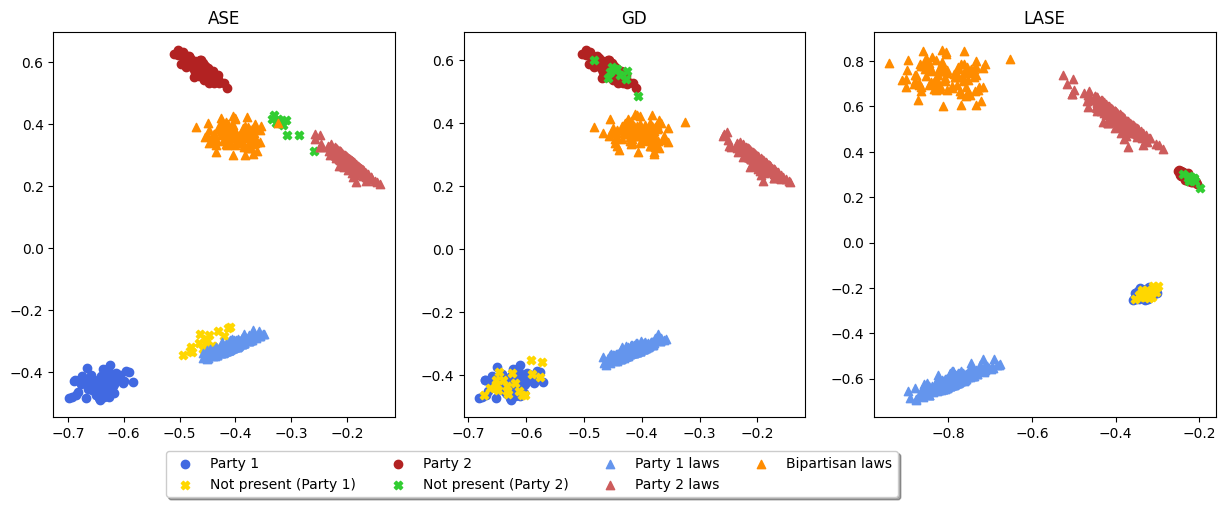

In [12]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import math
from training.get_init import get_x_init

torch.manual_seed(42)

d = 4
n_P1 = 100
n_P2 = 100
n_L1 = 200
n_L2 = 200
n_L3 = 100

P1_L1 = 0.8
P1_L2 = 0.01
P1_L3 = 0.2 
P2_L1 = 0.01
P2_L2 = 0.5
P2_L3 = 0.8


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 20
n_P2_np = 10
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.7).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)


x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)

x_init  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)

epochs = 300

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init=x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

In [11]:
from training.run_link_prediction import link_prediction

inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.2699, ASE acc: 0.7414, GD-GRDPG acc: 0.7414, GLASE acc: 0.2638, GLASE E2E acc: 0.2638


In [ ]:
from training.run_link_prediction import link_prediction

result = link_prediction(edge_index, mask, data, 5, 4)

GCN acc: 0.2638, ASE acc: 0.7414, GRDPG acc: 0.7414, GLASE acc: 0.7258


# ER mask

In [ ]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
import matplotlib.pyplot as plt
from torch_geometric.data import Data

torch.manual_seed(42)

d = 4
n_P1 = 100 # NUMERO DE SENADORES P1
n_P2 = 100 # NUMERO DE SENADORES P2
n_L1 = 200 # NUMERO DE LEYES P1
n_L2 = 200 # NUMERO DE LEYES P2
n_L3 = 60 # NUMERO DE LEYES NEUTRAS

P1_L1 = 0.9 ## Votos de senadores del partido 1 a leyes grupo 1
P1_L2 = 0.01 ## Votos de senadores del partido 1 a leyes grupo 2
P1_L3 = 0.2 ## Votos de senadores del partido 1 a leyes grupo 3
P2_L1 = 0.1 ## Votos de senadores del partido 2 a leyes grupo 1
P2_L2 = 0.8 ## Votos de senadores del partido 2 a leyes grupo 2
P2_L3 = 0.3 ## Votos de senadores del partido 2 a leyes grupo 3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
# n_P1_np = 20
# n_P2_np = 10
# senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

# mask = torch.ones([num_nodes,num_nodes]).squeeze(0)

# for i in senadores_no_presentes:
#     votos = (torch.rand(1, num_nodes) < 0.7).int()
#     mask[i,:] = votos
#     mask[:,i] = votos
    
mask_edge_index = erdos_renyi_graph(num_nodes, 0.7, directed=False)
mask = to_dense_adj(mask_edge_index, max_num_nodes=num_nodes).squeeze(0)
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)


x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 400

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)

tensor([[-1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  1.]])
Iteraciones:  17
Loss:  tensor(112.6790)
tensor(351.7845, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.4709, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.3480, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.2230, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(113.1156, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
mask

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 0., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 0.]], device='cuda:0')

In [ ]:
# mask_indexes = torch.nonzero(mask == 1, as_tuple=False)
# mask_indexes_x = mask_indexes[:,0].to('cpu')
# mask_indexes_y = mask_indexes[:,1].to('cpu')




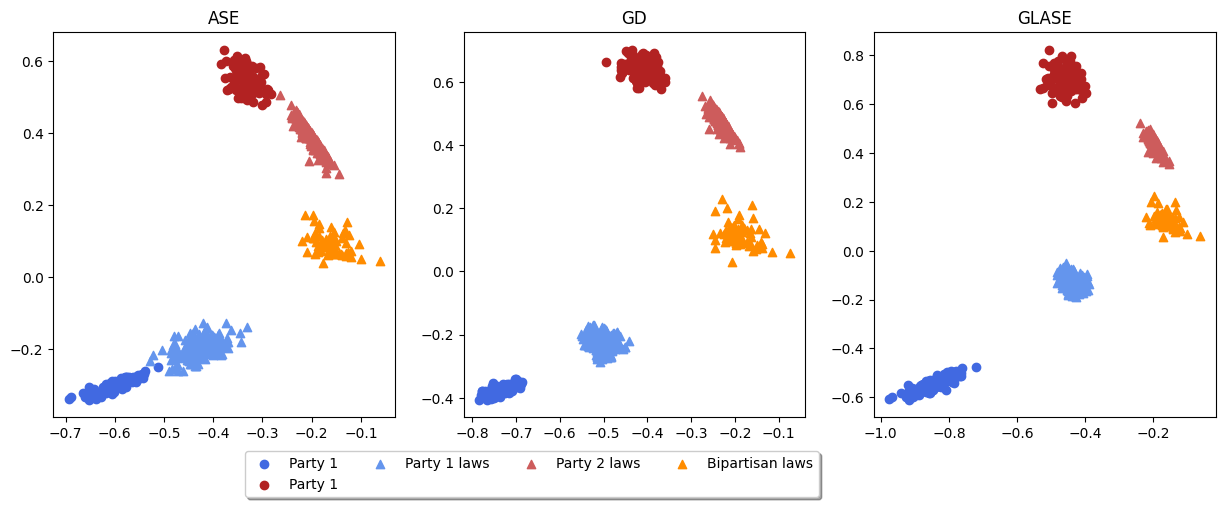

In [ ]:
fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[:n_P1,0],x_ase[:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2,0],x_ase[n_P1:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 1')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[:n_P1,0],x_grdpg[:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2,0],x_grdpg[n_P1:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[:n_P1,0],x_glase[:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2,0],x_glase[n_P1:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 1')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('GLASE')

plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

In [ ]:
from training.run_link_prediction import link_prediction

result = link_prediction(edge_index, mask, data, 5, 4)

GCN acc: 0.1787, ASE acc: 0.6075, GRDPG acc: 0.6280, GLASE acc: 0.6296
